# Regression Model for Superconductor Critical Temperature Using XGBoost Take 2
### David Lowe
### September 18, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Superconductor Critical Temperature dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: The research team wishes to create a statistical model for predicting the superconducting critical temperature based on the features extracted from the superconductor’s chemical formula. The model seeks to examine the features that can contribute the most to the model’s predictive accuracy.

From previous iterations, we constructed and tuned several classic machine learning models using the Scikit-Learn library. We also observed the best results that we could obtain from the models.

From iteration Take1, we constructed and tuned an XGBoost model. Furthermore, we applied the XGBoost model to a test dataset and observed the best result that we could obtain from the model.

In this Take2 iteration, we will construct and tune an XGBoost model using the additional material attributes available for modeling. Furthermore, we will apply the XGBoost model to a test dataset and observe the best result that we can obtain from the model.

ANALYSIS: From previous iterations, the Extra Trees model turned in the best overall result and achieved an RMSE metric of 9.56. By using the optimized parameters, the Extra Trees algorithm processed the test dataset with an RMSE of 9.32.

From iteration Take1, the baseline performance of the XGBoost algorithm achieved an RMSE benchmark of 12.88. After a series of tuning trials, the XGBoost model processed the validation dataset with an RMSE score of 9.88. When we applied the XGBoost model to the previously unseen test dataset, we obtained an RMSE score of 9.06.

In this Take2 iteration, the baseline performance of the XGBoost algorithm achieved an RMSE benchmark of 12.54. After a series of tuning trials, the XGBoost model processed the validation dataset with an RMSE score of 9.58. When we applied the XGBoost model to the previously unseen test dataset, we obtained an RMSE score of 8.94.

CONCLUSION: In this iteration, the additional material attributes improved the XGBoost model further for modeling this dataset. We should consider using the algorithm for further modeling.

Dataset Used: Superconductivity Data Set

Dataset ML Model: Regression with numerical attributes

Dataset Reference: https://archive.ics.uci.edu/ml/datasets/Superconductivty+Data

One potential source of performance benchmarks: https://doi.org/10.1016/j.commatsci.2018.07.052

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
!pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Sep  9 18:35:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve the memory configuration from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBRegressor

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'neg_mean_squared_error'

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-superconductor-critical-temperature/train.csv'
df_measurement = pd.read_csv(dataset_path)
df_measurement.drop(columns=['number_of_elements'], inplace=True)

dataset_path = 'https://dainesanalytics.com/datasets/ucirvine-superconductor-critical-temperature/unique_m.csv'
df_material = pd.read_csv(dataset_path)
df_material.drop(columns=['critical_temp','material'], inplace=True)

Xy_original = pd.concat([df_material, df_measurement], axis=1)
# Take a peek at the dataframe after import
print(Xy_original.head())

     H  He   Li  ...  std_Valence  wtd_std_Valence  critical_temp
0  0.0   0  0.0  ...     0.433013         0.437059           29.0
1  0.0   0  0.0  ...     0.632456         0.468606           26.0
2  0.0   0  0.0  ...     0.433013         0.444697           19.0
3  0.0   0  0.0  ...     0.433013         0.440952           22.0
4  0.0   0  0.0  ...     0.433013         0.428809           23.0

[5 rows x 167 columns]


In [11]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 167 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   H                                float64
 1   He                               int64  
 2   Li                               float64
 3   Be                               float64
 4   B                                float64
 5   C                                float64
 6   N                                float64
 7   O                                float64
 8   F                                float64
 9   Ne                               int64  
 10  Na                               float64
 11  Mg                               float64
 12  Al                               float64
 13  Si                               float64
 14  P                                float64
 15  S                                float64
 16  Cl                               float64
 17  Ar         

In [12]:
print(Xy_original.describe())

                  H       He  ...  wtd_std_Valence  critical_temp
count  21263.000000  21263.0  ...     21263.000000   21263.000000
mean       0.017685      0.0  ...         0.673987      34.421219
std        0.267220      0.0  ...         0.455580      34.254362
min        0.000000      0.0  ...         0.000000       0.000210
25%        0.000000      0.0  ...         0.306892       5.365000
50%        0.000000      0.0  ...         0.500000      20.000000
75%        0.000000      0.0  ...         1.020436      63.000000
max       14.000000      0.0  ...         3.000000     185.000000

[8 rows x 167 columns]


In [13]:
Xy_original.isnull().sum()

H                                  0
He                                 0
Li                                 0
Be                                 0
B                                  0
C                                  0
N                                  0
O                                  0
F                                  0
Ne                                 0
Na                                 0
Mg                                 0
Al                                 0
Si                                 0
P                                  0
S                                  0
Cl                                 0
Ar                                 0
K                                  0
Ca                                 0
Sc                                 0
Ti                                 0
V                                  0
Cr                                 0
Mn                                 0
Fe                                 0
Co                                 0
N

In [14]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [15]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'critical_temp': 'targetVar'})

# Convert columns from one data type to another
columns_int_to_float = Xy_original.columns[Xy_original.dtypes == 'int'].tolist()
Xy_original[columns_int_to_float] = Xy_original[columns_int_to_float].astype('float')
# Xy_original['range_atomic_radius'] = Xy_original['range_atomic_radius'].astype('float')
# Xy_original['range_Valence'] = Xy_original['range_Valence'].astype('float')

# Take a peek at the dataframe after cleaning
print(Xy_original.head())

     H   He   Li  ...  std_Valence  wtd_std_Valence  targetVar
0  0.0  0.0  0.0  ...     0.433013         0.437059       29.0
1  0.0  0.0  0.0  ...     0.632456         0.468606       26.0
2  0.0  0.0  0.0  ...     0.433013         0.444697       19.0
3  0.0  0.0  0.0  ...     0.433013         0.440952       22.0
4  0.0  0.0  0.0  ...     0.433013         0.428809       23.0

[5 rows x 167 columns]


In [16]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 167 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   H                                float64
 1   He                               float64
 2   Li                               float64
 3   Be                               float64
 4   B                                float64
 5   C                                float64
 6   N                                float64
 7   O                                float64
 8   F                                float64
 9   Ne                               float64
 10  Na                               float64
 11  Mg                               float64
 12  Al                               float64
 13  Si                               float64
 14  P                                float64
 15  S                                float64
 16  Cl                               float64
 17  Ar         

In [17]:
print(Xy_original.describe())

                  H       He  ...  wtd_std_Valence     targetVar
count  21263.000000  21263.0  ...     21263.000000  21263.000000
mean       0.017685      0.0  ...         0.673987     34.421219
std        0.267220      0.0  ...         0.455580     34.254362
min        0.000000      0.0  ...         0.000000      0.000210
25%        0.000000      0.0  ...         0.306892      5.365000
50%        0.000000      0.0  ...         0.500000     20.000000
75%        0.000000      0.0  ...         1.020436     63.000000
max       14.000000      0.0  ...         3.000000    185.000000

[8 rows x 167 columns]


In [18]:
Xy_original.isnull().sum()

H                                  0
He                                 0
Li                                 0
Be                                 0
B                                  0
C                                  0
N                                  0
O                                  0
F                                  0
Ne                                 0
Na                                 0
Mg                                 0
Al                                 0
Si                                 0
P                                  0
S                                  0
Cl                                 0
Ar                                 0
K                                  0
Ca                                 0
Sc                                 0
Ti                                 0
V                                  0
Cr                                 0
Mn                                 0
Fe                                 0
Co                                 0
N

In [19]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Attribute-only and Target-only Sets

In [20]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [21]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (21263, 167) X_original.shape: (21263, 166) y_original.shape: (21263,)


### 1.f) Set up the parameters for data visualization

In [22]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

In [23]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [24]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Descriptive Statistics

#### 2.a.i) Peek at the attribute columns

In [25]:
print(X_original.head())

     H   He   Li  ...  wtd_range_Valence  std_Valence  wtd_std_Valence
0  0.0  0.0  0.0  ...           1.085714     0.433013         0.437059
1  0.0  0.0  0.0  ...           1.128571     0.632456         0.468606
2  0.0  0.0  0.0  ...           1.114286     0.433013         0.444697
3  0.0  0.0  0.0  ...           1.100000     0.433013         0.440952
4  0.0  0.0  0.0  ...           1.057143     0.433013         0.428809

[5 rows x 166 columns]


#### 2.a.ii) Dimensions and attribute types

In [26]:
X_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 166 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   H                                float64
 1   He                               float64
 2   Li                               float64
 3   Be                               float64
 4   B                                float64
 5   C                                float64
 6   N                                float64
 7   O                                float64
 8   F                                float64
 9   Ne                               float64
 10  Na                               float64
 11  Mg                               float64
 12  Al                               float64
 13  Si                               float64
 14  P                                float64
 15  S                                float64
 16  Cl                               float64
 17  Ar         

#### 2.a.iii) Statistical summary of the attributes

In [27]:
print(X_original.describe())

                  H       He  ...   std_Valence  wtd_std_Valence
count  21263.000000  21263.0  ...  21263.000000     21263.000000
mean       0.017685      0.0  ...      0.839342         0.673987
std        0.267220      0.0  ...      0.484676         0.455580
min        0.000000      0.0  ...      0.000000         0.000000
25%        0.000000      0.0  ...      0.451754         0.306892
50%        0.000000      0.0  ...      0.800000         0.500000
75%        0.000000      0.0  ...      1.200000         1.020436
max       14.000000      0.0  ...      3.000000         3.000000

[8 rows x 166 columns]


### 2.b) Data Visualization

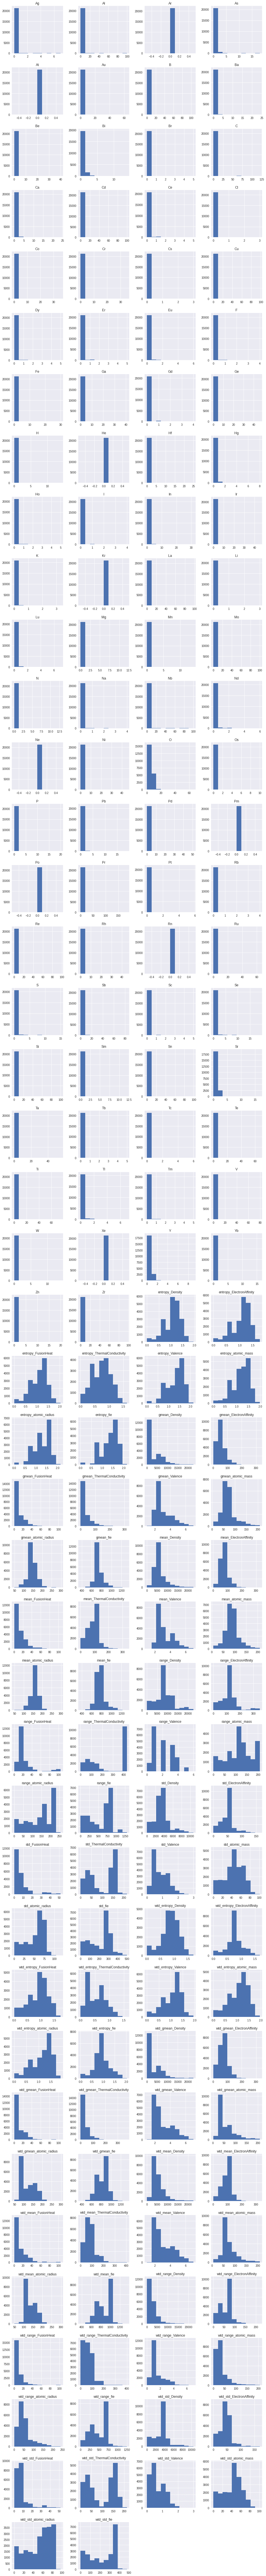

In [28]:
# Histograms for each attribute
X_original.hist(layout=(dispRow,dispCol))
plt.show()

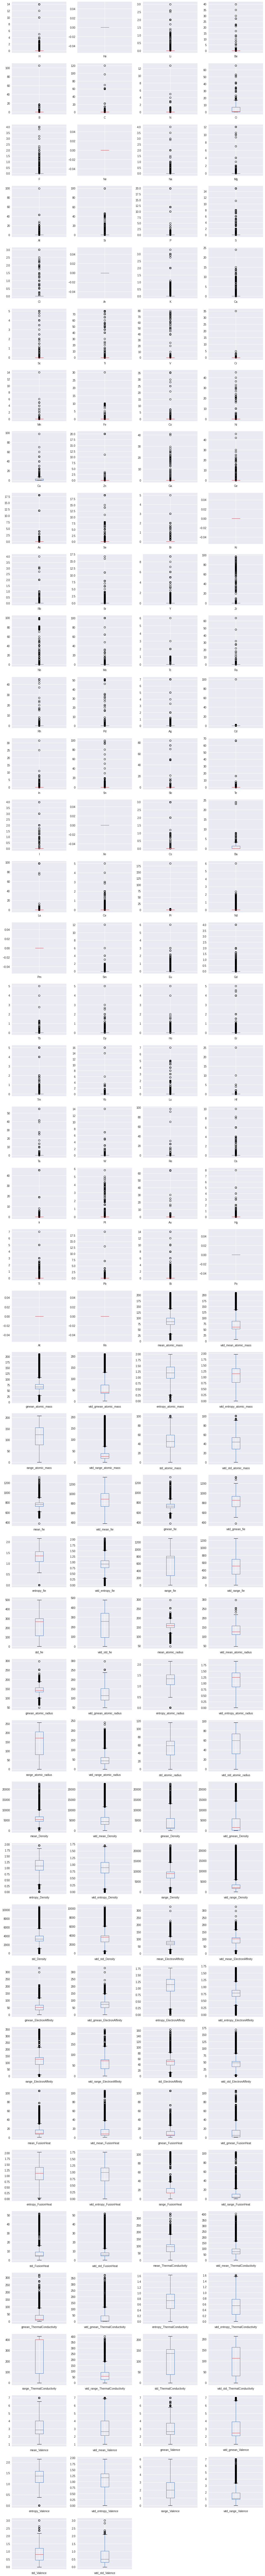

In [29]:
# Box and Whisker plot for each attribute
X_original.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

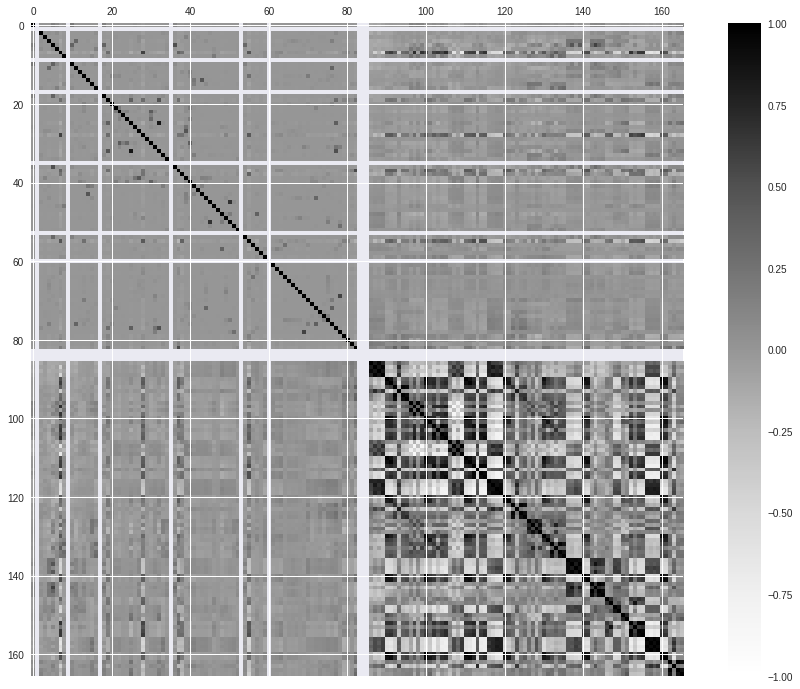

In [30]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_original.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [31]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [32]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [33]:
# Not applicable for this iteration of the project
# Perform one-hot-encoding on the categorical attributes
# X_original = pd.get_dummies(X_original)
# print(X_original.info())

In [34]:
# Split the data further into training, validation, and test datasets
X_train_val, X_test_df, y_train_val, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, random_state=seedNum)
X_train_df, X_validation_df, y_train_df, y_validation_df = train_test_split(X_train_val, y_train_val, test_size=val_set_size, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_validation_df.shape: {} y_validation_df.shape: {}".format(X_validation_df.shape, y_validation_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (12757, 166) y_train_df.shape: (12757,)
X_validation_df.shape: (4253, 166) y_validation_df.shape: (4253,)
X_test_df.shape: (4253, 166) y_test_df.shape: (4253,)


### 3.b) Feature Scaling and Data Pre-Processing

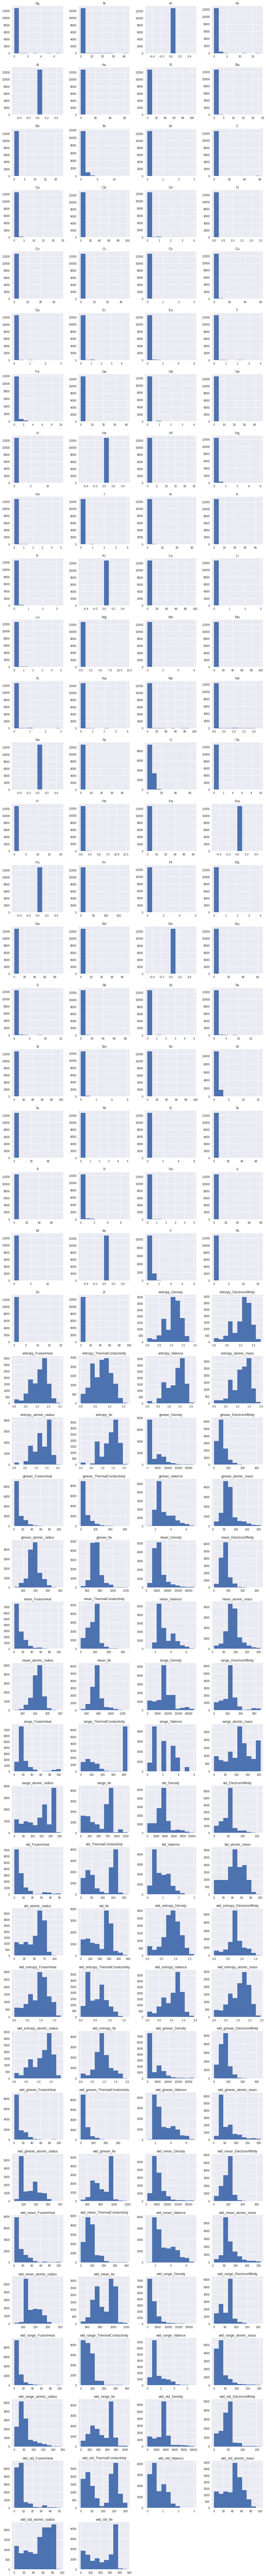

In [35]:
# Histograms for each attribute before pre-processing
columns_to_scale = X_train_df.columns[X_train_df.dtypes == 'float'].tolist()
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [36]:
# Apply feature scaling and transformation
print('Columns to scale are:', columns_to_scale)
scaler = preprocessing.MinMaxScaler()
X_train_df[columns_to_scale] = scaler.fit_transform(X_train_df[columns_to_scale])
print(X_train_df.head())

Columns to scale are: ['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass', 'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie', 'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie', 'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie', 'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius', 'wtd_gmean_atomic_radius', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

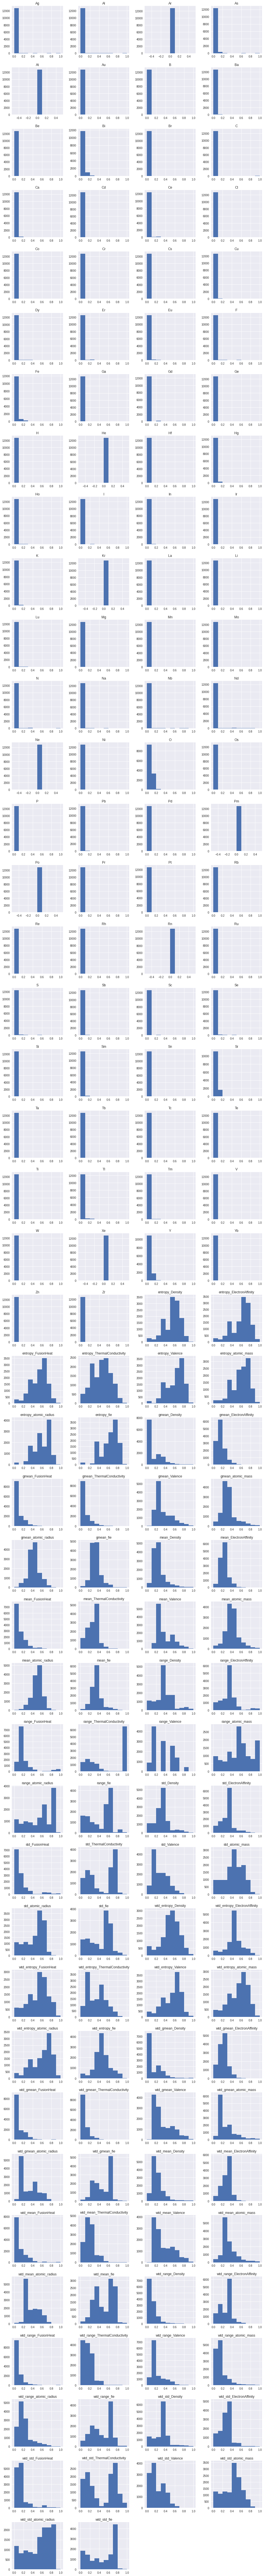

In [37]:
# Histograms for each attribute after pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [38]:
# Apply feature scaling and transformation to the validation dataset
scaled_features = scaler.transform(X_validation_df[columns_to_scale])
X_validation_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_validation_df.head())

         H   He   Li  ...  wtd_range_Valence  std_Valence  wtd_std_Valence
11987  0.0  0.0  0.0  ...           0.429129     0.000000         0.000000
1466   0.0  0.0  0.0  ...           0.149467     0.384900         0.324007
17982  0.0  0.0  0.0  ...           0.078024     0.133333         0.128565
17434  0.0  0.0  0.0  ...           0.125163     0.166667         0.124226
449    0.0  0.0  0.0  ...           0.119110     0.144338         0.089297

[5 rows x 166 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 3.c) Training Data Balancing

In [39]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [40]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [41]:
# Finalize the training and validation datasets for the modeling activities
X_train = X_train_df.to_numpy()
y_train = y_train_df.ravel()
X_validation = X_validation_df.to_numpy()
y_validation = y_validation_df.ravel()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))
print("X_validation.shape: {} y_validation.shape: {}".format(X_validation.shape, y_validation.shape))

X_train.shape: (12757, 166) y_train.shape: (12757,)
X_validation.shape: (4253, 166) y_validation.shape: (4253,)


In [42]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [43]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [44]:
# Set up Algorithms Spot-Checking Array
startTimeTraining = datetime.now()
startTimeModule = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('XGB', XGBRegressor(random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')))

In [45]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics ('+scoring+') from all models:',np.mean(train_metrics))
print ('Average RMSE for all models is:', math.sqrt((np.mean(train_metrics)*-1)))
print ('Total training time for all models:',(datetime.now() - startTimeTraining))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


XGB: -157.439014 (14.135720)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)
Model training time: 0:00:01.784913 

Average metrics (neg_mean_squared_error) from all models: -157.43901365893345
Average RMSE for all models is: 12.54747040876899
Total training time for all models: 0:00:01.805244


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


### 4.b) Spot-checking baseline algorithms

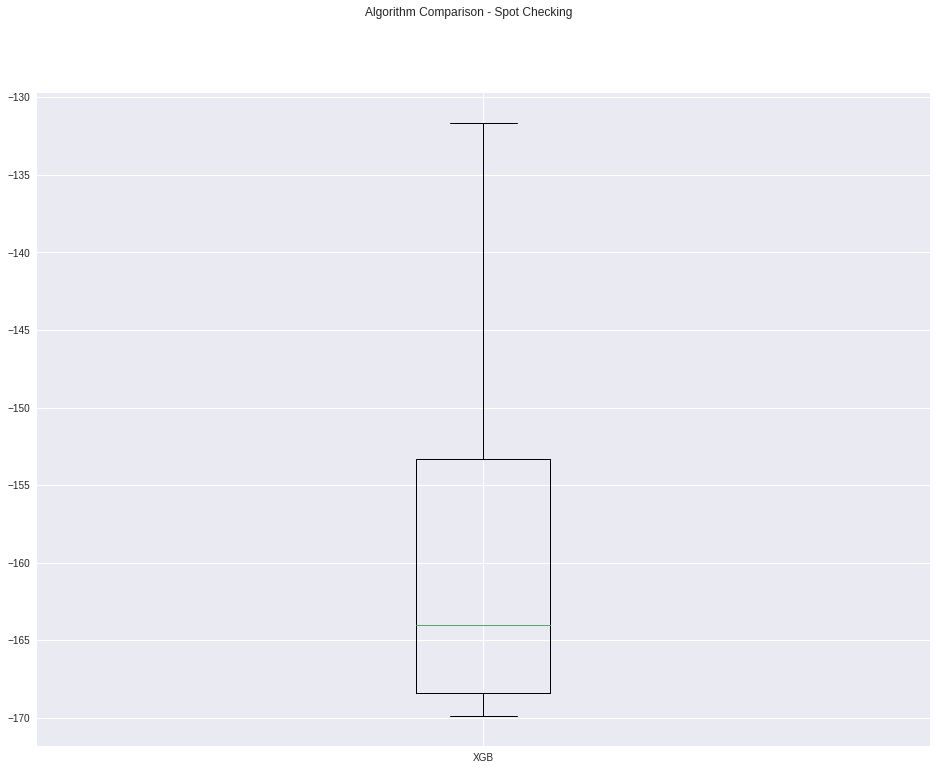

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [47]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [48]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [49]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [50]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBRegressor(random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100,1001,100), max_depth=np.array([3,6,9]), min_child_weight=np.array([1,2,3]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed: 19.6min finished


Best: -95.493794 using {'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 600}
-157.439014 (14.135720) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
-139.978399 (13.041303) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
-130.408069 (12.935206) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
-123.565511 (11.865565) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
-118.825299 (11.909722) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
-115.237379 (11.402740) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 600}
-112.635374 (11.200753) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 700}
-110.712642 (11.132261) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 800}
-108.952245 (11.099300) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 900}
-107.966653 (11.113587) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 1000}
-157.

In [51]:
# Tuning XGBoost subsample and colsample_bytree parameters
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBRegressor(n_estimators=600, max_depth=6, min_child_weight=2, random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7,0.8,0.9,1.0]), colsample_bytree=np.array([0.7,0.8,0.9,1.0]))

kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm tuning iteration #2 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  3.1min finished


Best: -95.333305 using {'colsample_bytree': 0.8, 'subsample': 1.0}
-95.734876 (8.743224) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
-95.584178 (8.896536) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
-95.520189 (9.909836) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
-96.691037 (8.830363) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
-95.826028 (8.537310) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
-96.031031 (9.998808) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
-95.392746 (10.087089) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
-95.333305 (8.926553) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
-96.206515 (8.302260) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
-96.725107 (9.581651) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
-95.365880 (10.121636) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
-95.659311 (9.178592) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
-96.124673 (9.512689) with: {'colsample_bytree': 1.0, 'subsample': 

### 5.b) Compare Algorithms After Tuning

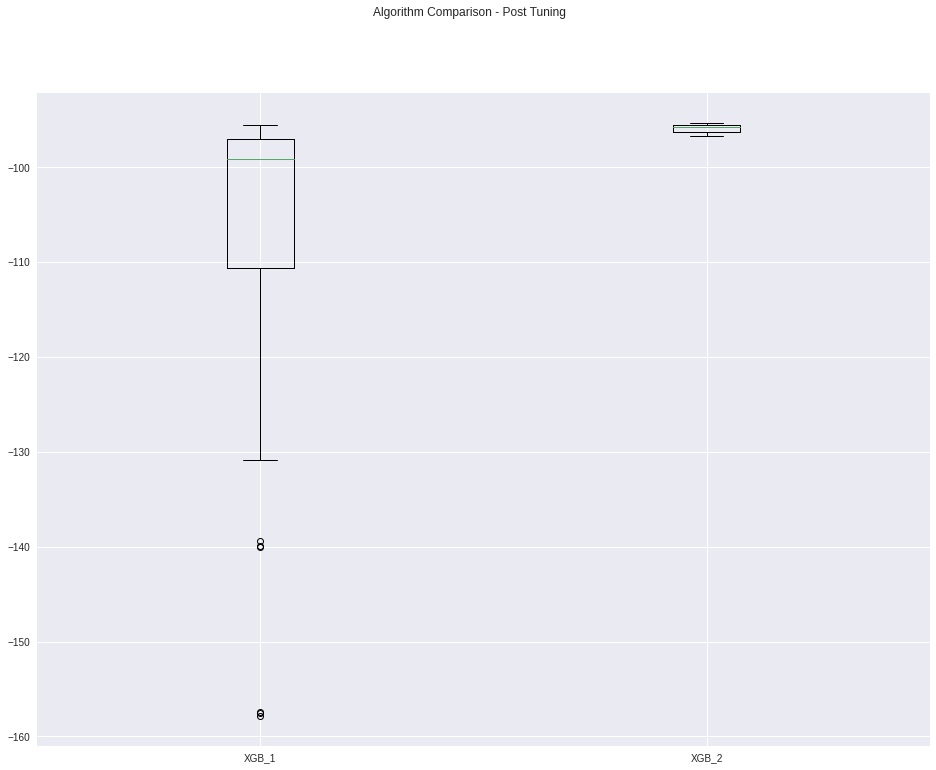

In [52]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [53]:
if notifyStatus: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [54]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Validate the models using the validation dataset

In [55]:
validation_model = XGBRegressor(n_estimators=600, max_depth=6, min_child_weight=2, colsample_bytree=0.8, subsample=1.0, random_state=seedNum, n_jobs=n_jobs, objective='reg:squarederror', tree_method='gpu_hist')
validation_model.fit(X_train, y_train)
print(validation_model)
val_predictions = validation_model.predict(X_validation)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_validation, val_predictions)))
print('R2 for the model is: ', r2_score(y_validation, val_predictions))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=2, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1.0, tree_method='gpu_hist',
             verbosity=1)
RMSE for the model is:  9.580859532920604
R2 for the model is:  0.9177691746838265


### 6.b) Create a test model using all available data

In [56]:
# Combining the training and validation datasets to form the complete dataset that will be used for training the final model
X_complete = np.vstack((X_train, X_validation))
y_complete = np.concatenate((y_train, y_validation))
print("X_complete.shape: {} y_complete.shape: {}".format(X_complete.shape, y_complete.shape))
test_model = validation_model.fit(X_complete, y_complete)
print(test_model)

X_complete.shape: (17010, 166) y_complete.shape: (17010,)
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=2, missing=None, n_estimators=600,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=888, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1.0, tree_method='gpu_hist',
             verbosity=1)


### 6.c) Load test dataset and measure predictions

In [57]:
# Apply feature scaling and transformation to the test dataset
scaled_features = scaler.transform(X_test_df[columns_to_scale])
X_test_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_test_df.head())

         H   He   Li  ...  wtd_range_Valence  std_Valence  wtd_std_Valence
11253  0.0  0.0  0.0  ...           0.071522     0.166667         0.152753
18632  0.0  0.0  0.0  ...           0.178804     0.157135         0.166667
3538   0.0  0.0  0.0  ...           0.149396     0.210819         0.090804
528    0.0  0.0  0.0  ...           0.157347     0.144338         0.146984
2985   0.0  0.0  0.0  ...           0.106261     0.124226         0.116642

[5 rows x 166 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
# Finalize the test dataset for the modeling testing
X_test = X_test_df.to_numpy()
y_test = y_test_df.ravel()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (4253, 166) y_test.shape: (4253,)


In [59]:
test_predictions = test_model.predict(X_test)
print('RMSE for the model is: ', math.sqrt(mean_squared_error(y_test, test_predictions)))
print('R2 for the model is: ', r2_score(y_test, test_predictions))

RMSE for the model is:  8.949065519353423
R2 for the model is:  0.9311929615682395


In [60]:
if notifyStatus: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [61]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:24:15.161634
